In [3]:
import pandas as pd
import numpy as np
import warnings
import scipy
from datetime import timedelta

# For marchine Learning Approach
from statsmodels.tsa.tsatools import lagmat
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\DELL LAPTOP\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
#opening data files #1.train_data, #2.
train_data=pd.read_csv("Train_data.csv")
test_data=pd.read_csv("Test_data.csv")
submission_data=pd.read_csv("Submission.csv")
train_data.head()

,Month,TransfersInMonth,BusinessDaysInMonth,IssuesInMonth
0,7/31/2007,867255,26.5,873516
1,8/31/2007,801252,22.0,872414
2,9/30/2007,811613,21.0,890435
3,10/31/2007,837920,27.5,851428
4,11/30/2007,801401,20.5,850625


In [5]:
#deviding data into two parts #1.train_data_transfer and #2.train_data_issue
train_data_transfer=pd.DataFrame(train_data,columns=["Month","TransfersInMonth","BusinessDaysInMonth"])
train_data_issue=pd.DataFrame(train_data,columns=["Month","IssuesInMonth"])

In [6]:
#merging train data and test data
train_data_transfer = [train_data_transfer,test_data]
train_data_transfer = pd.concat(train_data_transfer)
train_data_issue=[train_data_issue,submission_data]
train_data_issue = pd.concat(train_data_issue)

In [7]:
train_data_transfer.head()

,Month,TransfersInMonth,BusinessDaysInMonth
0,7/31/2007,867255,26.5
1,8/31/2007,801252,22.0
2,9/30/2007,811613,21.0
3,10/31/2007,837920,27.5
4,11/30/2007,801401,20.5


In [8]:
#Reseting Index
train_data_transfer.reset_index(drop=True,inplace=True)
train_data_issue.reset_index(drop=True,inplace=True)

In [9]:
# from train and test data i have taken TransfersInMonth and IssuesInMonth 
#for feature engineering and feature creation
train_test_1=pd.DataFrame(train_data_transfer,columns=["TransfersInMonth"])
train_test_2=pd.DataFrame(train_data_issue,columns=["IssuesInMonth"])
train_test = [train_test_1,train_test_2]
train_test = pd.concat(train_test,axis=1)

<h3><center>Framed a time series as a supervised learning dataset</h3>

In [84]:

""""
Framing a time series as a supervised learning dataset.
Arguments:
data: Sequence of observations as a list or NumPy array.
n_in: Number of lag observations as input (X).
n_out: Number of observations as output (y).
dropnan: Boolean whether or not to drop rows with NaN values.
Returns:
Pandas DataFrame of series framed for supervised learning.
"""
#used TransfersInMonth and IssuesInMonth for framing supervised learning data set
from pandas import DataFrame
from pandas import concat
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
raw = DataFrame()
raw['ob1'] =train_test["TransfersInMonth"]
raw['ob2'] = train_test["IssuesInMonth"]
values = raw.values
data = series_to_supervised(values,6)
data.head()

,var1(t-6),var2(t-6),var1(t-5),var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),var2(t)
6,867255.0,873516.0,801252.0,872414.0,811613.0,890435.0,837920.0,851428.0,801401.0,850625.0,812752.0,784745.0,783118,834803
7,801252.0,872414.0,811613.0,890435.0,837920.0,851428.0,801401.0,850625.0,812752.0,784745.0,783118.0,834803.0,817332,849328
8,811613.0,890435.0,837920.0,851428.0,801401.0,850625.0,812752.0,784745.0,783118.0,834803.0,817332.0,849328.0,811677,826523
9,837920.0,851428.0,801401.0,850625.0,812752.0,784745.0,783118.0,834803.0,817332.0,849328.0,811677.0,826523.0,797000,822965
10,801401.0,850625.0,812752.0,784745.0,783118.0,834803.0,817332.0,849328.0,811677.0,826523.0,797000.0,822965.0,808143,884723


In [103]:
#calling data after 6th row to form training set
modified_transfer=train_data_transfer[6:]
modified_transfer.shape

(120, 3)

In [15]:
#preparing the train_test data [Mixed data (Train+test)]
train_test_mixed_1=pd.DataFrame(modified_transfer,columns=["Month","BusinessDaysInMonth"])
train_test_mixed=pd.DataFrame(modified_transfer,columns=["BusinessDaysInMonth"])
train_test_mixed = [train_test_mixed,data]
train_test_mixed = pd.concat(train_test_mixed,axis=1)

In [16]:
#Final Train data
train_second=train_test_mixed[0:114]
#Final Test data
test_second=train_test_mixed[114:120]

In [18]:
#modeling using Machine learning
#training_data
x_train_second=pd.DataFrame(train_second,columns=["BusinessDaysInMonth","var1(t-6)","var2(t-6)","var1(t-5)","var2(t-5)","var1(t-4)","var2(t-4)","var1(t-3)","var2(t-3)","var1(t-2)","var2(t-2)","var1(t-1)","var2(t-1)","var1(t)"])
y_train_second=pd.DataFrame(train_second,columns=["var2(t)"])#target variable

x_train_second=Training data containg all features
 and y_train_second=Training data containing target value

Features considered for machine learning models:
   1. BusinessDaysInMonth
   2. Features related to varaiable TransfersInMonth are:
          var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1) and var1(t)
   3. Features related to varaiable IssuesInMonth are:
          var2(t-6),var2(t-5),var2(t-4),var2(t-3),var2(t-2),var2(t-1)
Target Variable:
   var2(t):value of IssuesInMonth at time t

In [19]:
x_train_second.head()

,BusinessDaysInMonth,var1(t-6),var2(t-6),var1(t-5),var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t)
6,25.5,867255.0,873516.0,801252.0,872414.0,811613.0,890435.0,837920.0,851428.0,801401.0,850625.0,812752.0,784745.0,783118
7,21.5,801252.0,872414.0,811613.0,890435.0,837920.0,851428.0,801401.0,850625.0,812752.0,784745.0,783118.0,834803.0,817332
8,22.0,811613.0,890435.0,837920.0,851428.0,801401.0,850625.0,812752.0,784745.0,783118.0,834803.0,817332.0,849328.0,811677
9,27.5,837920.0,851428.0,801401.0,850625.0,812752.0,784745.0,783118.0,834803.0,817332.0,849328.0,811677.0,826523.0,797000
10,21.0,801401.0,850625.0,812752.0,784745.0,783118.0,834803.0,817332.0,849328.0,811677.0,826523.0,797000.0,822965.0,808143


<h3><center>ML Approach</h3>

I have used a AdaBoostRegressor to train the model but also can try with other models to find the best model. I tried with a linear model as like Ridge but ADA model is better. It is possible to do a Neural Network approach too.

In [62]:
#modeling
# paramter tuning and modeling
from sklearn.ensemble import ExtraTreesRegressor,GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
#parameter tuning
param_dist = {
 'n_estimators': [50, 100],
 'learning_rate' : [0.01,0.03,0.04,0.05,0.1,0.3,1],
 'loss' : ['linear', 'square', 'exponential'],
 'random_state': [10,20,30,40,50,60]
 }

pre_gs_inst = RandomizedSearchCV(AdaBoostRegressor(),
 param_distributions = param_dist,
 cv=10,
 n_iter = 10,
 n_jobs=-1)

pre_gs_inst.fit(x_train_second, y_train_second)

C:\Users\DELL LAPTOP\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=10, error_score='raise',
          estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [50, 100], 'learning_rate': [0.01, 0.03, 0.04, 0.05, 0.1, 0.3, 1], 'loss': ['linear', 'square', 'exponential'], 'random_state': [10, 20, 30, 40, 50, 60]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [86]:
#best parameters after tuning
pre_gs_inst.best_params_

{'learning_rate': 1, 'loss': 'square', 'n_estimators': 100, 'random_state': 20}

In [87]:
#training the model using best parameters
model=  AdaBoostRegressor(n_estimators =100, random_state = 20, learning_rate=1,loss="square")
model.fit(x_train_second, y_train_second)
prediction_1 = model.predict(x_train_second)
prediction_1=pd.DataFrame(prediction_1)
#Mean absolute error for train prediction
mae = mean_absolute_error(y_train_second, prediction_1)
print ("mae with 116 the data to train:", mae)

C:\Users\DELL LAPTOP\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


mae with 116 the data to train: 15855.5951604


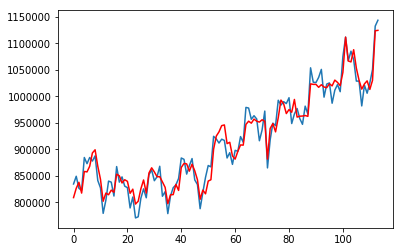

In [115]:
#plotting actual vs predicted in training data
from matplotlib import pyplot
pyplot.plot(y_train_second)
pyplot.plot(prediction_1, color='red')
pyplot.show()

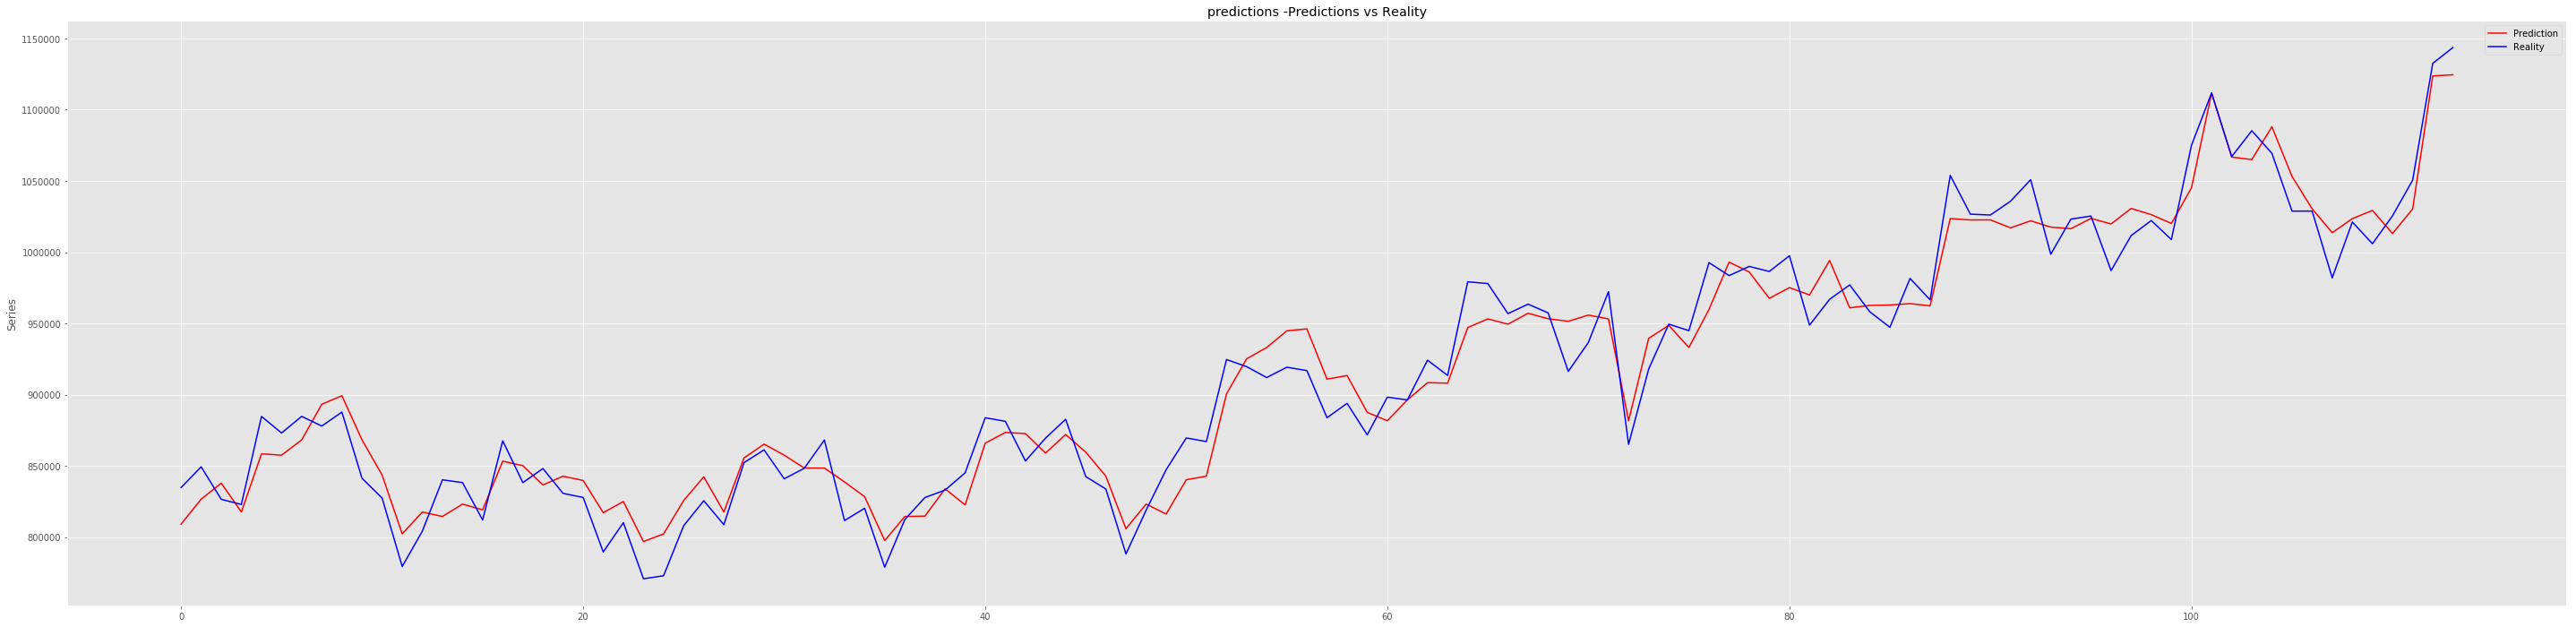

In [134]:
#visualisation
plt.style.use('ggplot')
plt.figure(figsize=(50, 12))
prediction_train=np.array(prediction_1)
#predicted:red
line_up, = plt.plot(prediction_train,label='Prediction',color='red')
#actual:blue
line_down, = plt.plot(np.array(y_train_second),label='Reality',color='blue')
plt.ylabel('Series')
plt.legend(handles=[line_up, line_down])
plt.title('predictions -Predictions vs Reality')
plt.show()

In [65]:
#calculating MAPE: mean absolute error function
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

In [66]:
#Mean absolute eror for train prediction
mean_absolute_percentage_error(y_train_second,prediction_1)

1.7497135674796767

train MAPE:1.7497135674796767

<h5><center>TEST_PREDICTION</h5>

In [67]:
#test_prediction
x_test=pd.DataFrame(test_second,columns=["BusinessDaysInMonth","var1(t-6)","var2(t-6)","var1(t-5)","var2(t-5)","var1(t-4)","var2(t-4)","var1(t-3)","var2(t-3)","var1(t-2)","var2(t-2)","var1(t-1)","var2(t-1)","var1(t)"])
x_test

,BusinessDaysInMonth,var1(t-6),var2(t-6),var1(t-5),var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t)
120,27.0,996091.0,1021160.0,928621.0,1005903.0,927348.0,1025539.0,988990.0,1050488.0,978562.0,1132481.0,1047903.0,1143552.0,1056019
121,22.0,928621.0,1005903.0,927348.0,1025539.0,988990.0,1050488.0,978562.0,1132481.0,1047903.0,1143552.0,1056019.0,0.0,1021590
122,21.0,927348.0,1025539.0,988990.0,1050488.0,978562.0,1132481.0,1047903.0,1143552.0,1056019.0,0.0,1021590.0,0.0,1010038
123,27.5,988990.0,1050488.0,978562.0,1132481.0,1047903.0,1143552.0,1056019.0,0.0,1021590.0,0.0,1010038.0,0.0,1067153
124,20.5,978562.0,1132481.0,1047903.0,1143552.0,1056019.0,0.0,1021590.0,0.0,1010038.0,0.0,1067153.0,0.0,1042316
125,20.0,1047903.0,1143552.0,1056019.0,0.0,1021590.0,0.0,1010038.0,0.0,1067153.0,0.0,1042316.0,0.0,1059981


In [119]:
#predicting test data
prediction_test_1 = model.predict(x_test[0:1])
x_test.iloc[1,12]=prediction_test_1
x_test.iloc[2,10]=prediction_test_1
x_test.iloc[3,8]=prediction_test_1
x_test.iloc[4,6]=prediction_test_1
x_test.iloc[5,4]=prediction_test_1

In [69]:
prediction_test_1

array([ 1057494.83333333])

In [120]:
prediction_test_2 = model.predict(x_test[1:2])
x_test.iloc[2,12]=prediction_test_2
x_test.iloc[3,10]=prediction_test_2
x_test.iloc[4,8]=prediction_test_2
x_test.iloc[5,6]=prediction_test_2

In [121]:
prediction_test_2

array([ 1050167.28])

In [122]:
prediction_test_3 = model.predict(x_test[2:3])
x_test.iloc[3,12]=prediction_test_3
x_test.iloc[4,10]=prediction_test_3
x_test.iloc[5,8]=prediction_test_3

In [73]:
prediction_test_3

array([ 1066717.11764706])

In [131]:
prediction_test_4 = model.predict(x_test[3:4])
x_test.iloc[4,12]=prediction_test_4
x_test.iloc[5,10]=prediction_test_4

In [132]:
prediction_test_4

array([ 1067977.57142857])

In [76]:
prediction_test_5 = model.predict(x_test[4:5])
x_test.iloc[5,12]=prediction_test_5
x_test

,BusinessDaysInMonth,var1(t-6),var2(t-6),var1(t-5),var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t)
120,27.0,996091.0,1021160.0,928621.0,1.005903e+06,927348.0,1.025539e+06,988990.0,1.050488e+06,978562.0,1.132481e+06,1047903.0,1.143552e+06,1056019
121,22.0,928621.0,1005903.0,927348.0,1.025539e+06,988990.0,1.050488e+06,978562.0,1.132481e+06,1047903.0,1.143552e+06,1056019.0,1.057495e+06,1021590
122,21.0,927348.0,1025539.0,988990.0,1.050488e+06,978562.0,1.132481e+06,1047903.0,1.143552e+06,1056019.0,1.057495e+06,1021590.0,1.050167e+06,1010038
123,27.5,988990.0,1050488.0,978562.0,1.132481e+06,1047903.0,1.143552e+06,1056019.0,1.057495e+06,1021590.0,1.050167e+06,1010038.0,1.066717e+06,1067153
124,20.5,978562.0,1132481.0,1047903.0,1.143552e+06,1056019.0,1.057495e+06,1021590.0,1.050167e+06,1010038.0,1.066717e+06,1067153.0,1.067978e+06,1042316
125,20.0,1047903.0,1143552.0,1056019.0,1.057495e+06,1021590.0,1.050167e+06,1010038.0,1.066717e+06,1067153.0,1.067978e+06,1042316.0,1.083304e+06,1059981


In [77]:
prediction_test_5

array([ 1083303.58823529])

In [78]:
prediction_test_6 = model.predict(x_test[5:6])
prediction_test_6

array([ 1073877.66666667])

In [79]:
prediction_test_1=DataFrame(prediction_test_1)
prediction_test_2=DataFrame(prediction_test_2)
prediction_test_3=DataFrame(prediction_test_3)
prediction_test_4=DataFrame(prediction_test_4)
prediction_test_5=DataFrame(prediction_test_5)
prediction_test_6=DataFrame(prediction_test_6)

In [80]:
prediction_final = [prediction_test_1,prediction_test_2,prediction_test_3,prediction_test_4,prediction_test_5,prediction_test_6]
prediction_final = pd.concat(prediction_final,axis=0)

In [81]:
prediction_final.reset_index(drop=True,inplace=True)

In [82]:
submission_data["IssuesInMonth"]=prediction_final

In [130]:
submission_data.to_csv('submission_data.csv')

In [118]:
submission_data

,Month,IssuesInMonth
0,7/31/2017,1.057495e+06
1,8/31/2017,1.050167e+06
2,9/30/2017,1.066717e+06
3,10/31/2017,1.067978e+06
4,11/30/2017,1.083304e+06
5,12/31/2017,1.073878e+06


ploting predicted test data

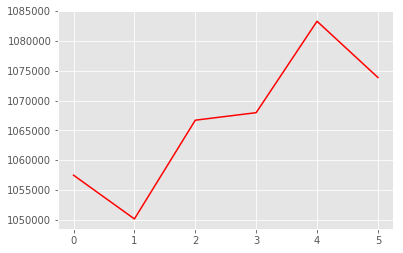

In [133]:
#plotting predicted value
predicted_test=submission_data.iloc[:,1:2]
pyplot.plot(predicted_test,color='red')
pyplot.show()